In [1]:
# Using clustering for preprocessing

from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [3]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [4]:
# baseline 
log_reg.score(X_test, y_test)

0.9666666666666667

In [5]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, n_init='auto', random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans',
                 KMeans(n_clusters=50, n_init='auto', random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [6]:
pipeline.score(X_test, y_test)

0.98

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, n_init='auto',
                                               random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [8]:
grid_clf.best_params_

{'kmeans__n_clusters': 97}

In [9]:
grid_clf.score(X_test, y_test)

0.9844444444444445

In [10]:
# using clustering for semi-supervised learning

n_labeled = 50
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [11]:
log_reg.score(X_test, y_test)

0.8222222222222222

In [12]:
import numpy as np
k = 50
kmeans = KMeans(n_clusters=k, n_init='auto', max_iter=5000, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

<function matplotlib.pyplot.show(close=None, block=None)>

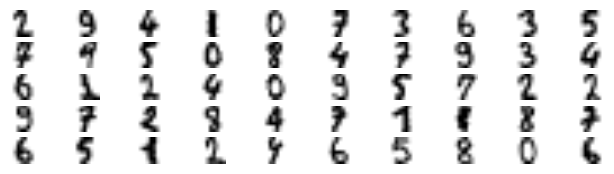

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show

In [14]:
# normally we should manually label those representative digits (i.e. semi-supervised learning) but we have cheated here, using the labels in y_train
y_representative_digits = y_train[representative_digit_idx]

In [15]:
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [16]:
log_reg.score(X_test, y_test)

0.9155555555555556

In [17]:
# propagate the labels
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [18]:
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9111111111111111

In [19]:
# propagate the labels to only the 20% of the instances that are closest to the centroids

percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]  # This is an array of distances from the instances to their cluster centroids
for i in range(k):
    in_cluster = (kmeans.labels_ == i)  # array of booleans indicating whether or not that instance is in the i-th cluster
    cluster_dist = X_cluster_dist[in_cluster]  # array of distances from instances in the i-th cluster to the i-th cluster centroid.
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)  # the distance that is at 20% of the distances in the array.
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1  # mark the instances in this cluster but beyong 20% distance cutoff to the centroid.

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [20]:
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9088888888888889

In [21]:
# check how accurate the propagated labels are
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.993006993006993

In [22]:
# DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [23]:
dbscan.labels_

array([ 0,  1,  2,  3,  0,  3,  4,  1,  4,  2,  0,  3,  0,  0,  5, -1,  3,
        7,  4,  0,  3,  4,  2,  2,  2,  0, -1,  3,  1,  6,  3,  0,  2,  2,
        7,  2,  7,  0,  8, -1,  2,  6,  0,  3,  3,  2,  0,  0,  2,  2,  2,
        4,  0,  6,  4,  5, -1,  0,  7,  2,  2,  2, -1,  3, 10,  2,  3,  3,
        3,  2,  2,  2,  5,  0,  6,  8,  8,  3,  0,  4,  7,  8,  0,  7,  5,
        4,  0,  5,  0,  7,  8,  5,  2, 10,  7,  3,  8, -1, 12,  2,  8,  0,
        3,  0,  3,  0,  7,  7,  7,  0,  0,  1,  0,  4,  0,  8,  3,  2,  9,
        2,  3,  8,  4,  3,  0,  2,  2,  0,  7,  0,  2,  0,  2,  0,  5,  8,
        0,  0,  0,  8,  7,  3,  0,  8,  2,  3,  2,  7,  2,  2,  8,  2,  0,
       10,  7,  8,  2,  2,  2,  3,  8,  2,  2,  3,  7,  0,  2, 10,  2,  0,
        3,  0,  2,  0,  3, -1,  7,  5,  5,  2,  0,  3,  1, -1,  3,  1,  2,
        7,  0,  0,  1,  7,  2,  3,  8,  0,  0,  3,  8,  7,  2,  3, -1,  0,
        0,  1,  8,  3,  8,  7,  3,  2,  8,  6,  2,  3,  7,  3,  0,  2,  4,
        2,  2,  5,  3,  0

In [24]:
len(dbscan.core_sample_indices_)

793

In [25]:
dbscan.core_sample_indices_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  16,  19,  20,  23,  24,  25,  27,  29,  30,  32,  34,
        36,  37,  38,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  58,  59,  60,  61,  63,  65,  66,
        69,  70,  72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  88,  90,  91,  92,  94,  95,  96, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116,
       118, 120, 121, 123, 125, 126, 127, 128, 129, 131, 132, 133, 134,
       135, 136, 137, 138, 140, 141, 142, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 177, 178,
       179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 193,
       194, 195, 196, 197, 198, 199, 201, 203, 204, 205, 206, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 218, 220, 221, 222, 22

In [29]:
dbscan.components_

array([[ 0.30396761,  0.89724748],
       [ 1.9513014 ,  0.40418927],
       [ 2.01633363,  0.16172974],
       ...,
       [-0.94157449,  0.21901823],
       [-0.55137263,  0.76191458],
       [ 0.44123987, -0.30962605]])

In [30]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [27]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [28]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [31]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

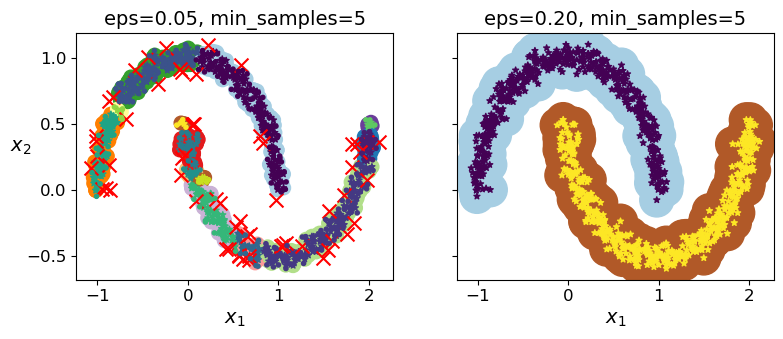

In [33]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()